# Temperature Equilibration

Notebook illustrates temperature equilibration between electrons and ions through Coulomb scattering

In [1]:
# import Python libraries
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
from IPython.display import Markdown as md

# import TFLink libraries
import sys
sys.path.append("/Users/mlavell/Documents/research/TriForce/TFNavi")
import Maxwell_HDF5_reader as emH5
import ParticlePusher_HDF5_reader as ppH5
import TFNavi as navi

In [2]:
# constants
Mi= 1.67262192e-27
Me= 9.10938356e-31
qe= 1.60217663e-19
MH=1  # atomic number hydrogen
MC=6  # carbon
MO=16 # oxygen 
Kb= 1.38064852e-23
eps0= 8.8541878128e-12
tol = 1e-27

# function returns temperature and velocity drift
def getTempDrift(velx,mass):
    nparts = np.shape(velx)[0]
    sumV2 = 0; sumVDrift = np.zeros(3)
    for p in range(nparts):
        sumV2     += np.sum(velx[p]**2)
        sumVDrift += velx[p]
    temp   = mass/(3*Kb) * abs(sumV2/nparts-np.sum((sumVDrift/nparts)**2))
    vdrift = sumVDrift/nparts
    return temp,vdrift

# function returns Debye length for single species
def getDebyeLength(ndens,atomNum,temp):
    rmin = (4.0*np.pi*ndens/3.0)**(-1/3) # min mean interatomic distance
    debyelength = (ndens*(qe*atomNum)**2/(eps0*Kb*temp))**(-0.5)
    return max(rmin,debyelength)

# function returns Debye length for two species
def getDebyeLengthTwoSpecies(ndens1,atomNum1,temp1,ndens2,atomNum2,temp2):
    # min mean interatomic distance
    rmin = (4.0*np.pi*max(ndens1,ndens2)/3.0)**(-1/3)
    ldm2   = (ndens1*(qe*atomNum1)**2/(eps0*Kb*temp1) + ndens2*(qe*atomNum2)**2/(eps0*Kb*temp2))
    return max(rmin,ldm2**(-0.5))

# function returns plasma frequency
def getPlasmaFrequency(ndens,chrg,mass):
    return (ndens*(qe*chrg)**2/(eps0*mass))**0.5

# function returns array of velocity norms
def getVelocityNorm(vec3,nsteps):
    vnorm = np.zeros(nsteps)
    for s in range(nsteps):
        vnorm[s]= np.linalg.norm(vec3[s,:])
    return vnorm

# function returns thermal velocity
def getThermalVelocity(temperature,mass):
    return np.sqrt(Kb*temperature/mass)

### Load data and compute particle temperature and velocity drift

In [3]:
# load particle data
pdata = ppH5.easy_read('data/tempEquil_')

nParticles= pdata.frames[0].n_particles
charge    = pdata.frames[0].charges
mass      = pdata.frames[0].masses
spid      = pdata.frames[0].spids

iC1=[] # carbon population indicis
iC2=[]

for ip in range(nParticles):
    if   spid[ip] == 0: iC1.append(ip) # 1keV C
    elif spid[ip] == 1: iC2.append(ip) # 250eV C

nsteps= np.shape(pdata.frames)[0]
tps= np.zeros(nsteps)


# load field data ~~~~~~~~~~~~~~~~~`
fdata = emH5.easy_read('data/tempEquil_')

# grid
xmin, xmax= ( 0, 1e-5)
ymin, ymax= ( 0, 1e-5)
zmin, zmax= ( 0, 1e-5)
vol= (xmax-xmin)*(ymax-ymin)*(zmax-zmin)

nx= fdata.frames[0].dims[0]
ny= fdata.frames[0].dims[1]
nz= fdata.frames[0].dims[2]

dx = (xmax-xmin)/nx
dy = (xmax-xmin)/ny
dz = (xmax-xmin)/nz

xx= np.linspace(xmin, xmax, nx)
yy= np.linspace(ymin, ymax, ny)
zz= np.linspace(zmin, zmax, nz)

print("Finished loading.")

Finished loading.


In [4]:
TC1 = np.zeros(nsteps)
TC2 = np.zeros(nsteps)

vC1 = np.zeros((nsteps,3))
vC2 = np.zeros((nsteps,3))

for istep in range(nsteps):
    tps[istep]= 1e12*pdata.frames[istep].time
    TC1[istep],vC1[istep,:]= getTempDrift(pdata.frames[istep].velocities[iC1],pdata.frames[istep].masses[iC1[0]])
    TC2[istep],vC2[istep,:]= getTempDrift(pdata.frames[istep].velocities[iC2],pdata.frames[istep].masses[iC2[0]])
    
# read number density from output; we should read in parms file..
ndens=1e26
lambdaDebye= getDebyeLength(ndens,1,TC1[0]) 
DX=min(min(dx,dy),dz)

# velocity magnitude
vnC1 = getVelocityNorm(vC1,nsteps)
vnC2 = getVelocityNorm(vC2,nsteps)

# thermal velocity
vthC1= getThermalVelocity(TC1[0],Mi*MC)
vthC2= getThermalVelocity(TC2[0],Mi*MC)

print("Finished analysis.")

Finished analysis.


In [5]:
print("Carbon_1 temperature = % 5.2e K = % 5.2f eV" %(TC1[0],TC1[0]/1.1606e4))
print("Carbon_2 temperature = % 5.2e K = % 5.2f eV" %(TC2[0],TC2[0]/1.1606e4))
print("")
print("DebyeLength_electron = % 5.2f um" %(lambdaDebye*1e6))
print("                  dx = % 5.2f um" %(DX*1e6))
print("")
print("             C1 ions = "+str(len(iC2)))
print("             C1 ions = "+str(len(iC1)))
print("")
print(" C1 thermal velocity = %5.2e m/s" %(vthC1))
print(" C2 thermal velocity = %5.2e m/s" %(vthC2))

Carbon_1 temperature =  1.17e+07 K =  1006.04 eV
Carbon_2 temperature =  2.81e+06 K =  241.88 eV

DebyeLength_electron =  0.02 um
                  dx =  5.00 um

             C1 ions = 514
             C1 ions = 486

 C1 thermal velocity = 1.27e+05 m/s
 C2 thermal velocity = 6.21e+04 m/s


### Plot temperature and velocity evolution

Expect to see constant temperature of 5eV and no drift.

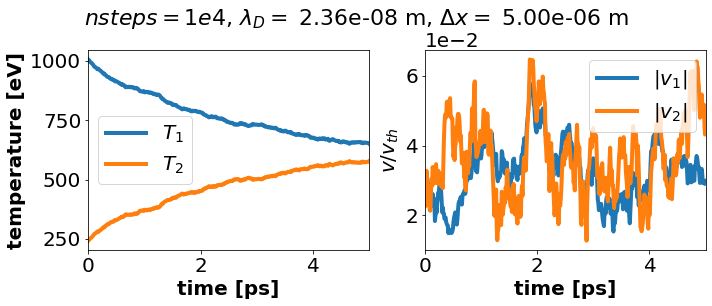

In [6]:
fig, ax = plt.subplots(1,2,figsize=(10,4),tight_layout=True)
fig.suptitle(r"$nsteps=1e4$, $\lambda_D =$ %5.2e m, $\Delta x =$ %5.2e m"%(lambdaDebye,DX),fontsize=22,y=1.05)

# plot temperature ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax[0].set_xlabel(r'time [ps]',fontsize=20,weight='bold')
ax[0].set_ylabel(r'temperature [eV]',fontsize=20,weight='bold')

# plot histograms for ions
ax[0].plot(tps,TC1/11601.,linewidth=4,label=r'$T_1$')
ax[0].plot(tps,TC2/11601.,linewidth=4,label=r'$T_2$')

ax[0].set_xlim([tps[0],tps[-1]])
#ax[0].set_ylim([4,6])
ax[0].tick_params(labelsize=20)
ax[0].legend(fontsize=20)


# plot vx drift ~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
ax[1].set_xlabel(r'time [ps]',fontsize=20,weight='bold')
ax[1].set_ylabel(r'$v/v_{th}$',fontsize=20,weight='bold') #[m/s]

# specific velocity direction
#ax[1].plot(tps,eVelx[:,0]/vthe,linewidth=4,label=r'$v_{x,e}$')
#ax[1].plot(tps,HVelx[:,0]/vthH,linewidth=4,label=r'$v_{x,H}$')
#ax[1].plot(tps,CVelx[:,0]/vthC,linewidth=4,label=r'$v_{x,C}$')
#ax[1].plot(tps,OVelx[:,0]/vthO,linewidth=4,label=r'$v_{x,O}$')

# velocity magnitude
ax[1].plot(tps,vnC1/vthC1,linewidth=4,label=r'$|v_1|$')
ax[1].plot(tps,vnC2/vthC2,linewidth=4,label=r'$|v_2|$')

ax[1].set_xlim([tps[0],tps[-1]])
ax[1].tick_params(labelsize=20)
ax[1].ticklabel_format(style='sci', axis='y', scilimits=(0,0))
ax[1].yaxis.offsetText.set_fontsize(20)
ax[1].legend(fontsize=20)

plt.show()

### Analytic fluid solution

See Rambo 1995, A comparison of kinetic and multifluid simulations of laser-produced colliding plasmas, Eq.7

1724140303369.6865


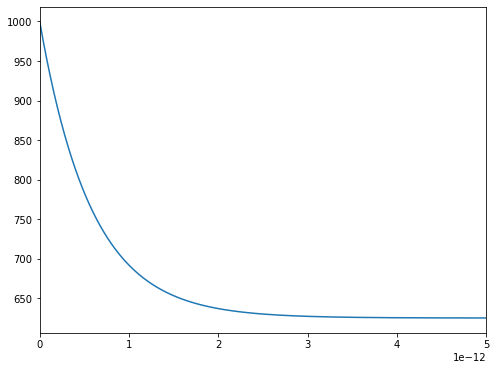

In [7]:
Mi= 1.66054e-24 #g
e=  4.8e-10     #sc
logLambda=10.0
TA0=1000
TB0=250
nB=1e20
ZC=6
mC=12*Mi

ev2erg=1.60218e-12


def equilibrationRate(Z,m,n,logL,TA,TB):
    return 4*(2*np.pi)**0.5*(Z*e)**4*logL*n/(m*(ev2erg*(TA+TB))**3)**0.5
    #return 8*np.pi**0.5*(Z*e)**4.0*logL*n/(3.0*m**0.5*Ts**(1.5))

def fluidTA(TA0,TB0,mu,t):
    return 0.5*(TA0+TB0)+0.5*(TA0-TB0)*np.exp(-mu*t)

pts=np.size(tps)
time= tps*1e-12 # np.linspace(0,5.0e-12,pts)

#mu= equilibrationRate(ZC,mC,nB,logLambda,0.5*(TA0+TB0))
mu= equilibrationRate(ZC,mC,nB,logLambda,TA0,TB0)
print(mu)


TF1=np.zeros(pts)
for i in range(pts):
    #TFl[p]= fluidTA(1000,250,mu,time[p])
    TF1[i]=0.5*(TA0+TB0)+0.5*(TA0-TB0)*np.exp(-mu*time[i])
    
fig,ax=plt.subplots(1,1,figsize=(8,6))
#ax.set_ylim([500,1000])
ax.set_xlim([0,time[-1]])
ax.plot(time,TF1)


## TFNavi Plot

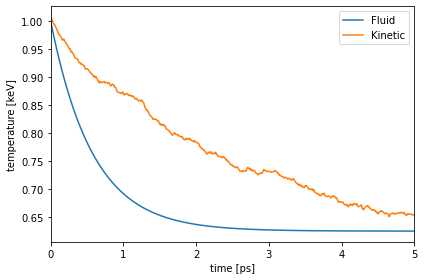

In [8]:
fluidTemp=TF1/1000
kineticTemp=TC1/11601./1000

lbls=['Fluid','Kinetic']

dset=navi.LinePlot(xdata=tps,ydata=[fluidTemp,kineticTemp],
              labels=lbls,xlabel="time [ps]",ylabel="temperature [keV]")
navi.make_subplots(dset,nrows=1,ncols=1)